## HyperParameter

In [6]:
class Config:
    num_epochs = 300
    input_size = 240*180*2
    hidden_size = 256
    batch_size = 64

    #for Temporal
    window_size = 0.05
    padding = 0
    estimate_time = 0.03

    #for Discrete
    frame_size = 10000
    padding_size = 0
    estimate_size = 5000

##Model

In [ ]:
import torch
import torch.nn as nn

In [ ]:
TF_DIM = 240*180*2
TF_FC_DIM = 1024
TF_DROPOUT = 0.4
TF_LAYERS = 4
TF_NHEAD = 4

In [ ]:

class PositionalEncoding(torch.nn.Module):
    """Classic Attention-is-all-you-need positional encoding."""

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)


def generate_square_subsequent_mask(size: int) -> torch.Tensor:
    """Generate a triangular (size, size) mask."""
    mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
    return mask


In [ ]:
import argparse
from typing import Any, Dict

class LineCNNTransformer(nn.Module):
    """Process the line through a CNN and process the resulting sequence with a Transformer decoder"""

    def __init__(
        self,
        data_config: Dict[str, Any],
        args: argparse.Namespace = None,
    ) -> None:
        super().__init__()
        self.data_config = data_config
        self.input_dims = data_config["input_dims"]
        self.num_classes = len(data_config["mapping"])
        inverse_mapping = {val: ind for ind, val in enumerate(data_config["mapping"])}
        self.start_token = inverse_mapping["<S>"]
        self.end_token = inverse_mapping["<E>"]
        self.padding_token = inverse_mapping["<P>"]
        self.max_output_length = data_config["output_dims"][0]
        self.args = vars(args) if args is not None else {}

        self.dim = self.args.get("tf_dim", TF_DIM)
        tf_fc_dim = self.args.get("tf_fc_dim", TF_FC_DIM)
        tf_nhead = self.args.get("tf_nhead", TF_NHEAD)
        tf_dropout = self.args.get("tf_dropout", TF_DROPOUT)
        tf_layers = self.args.get("tf_layers", TF_LAYERS)

        # Instantiate LineCNN with "num_classes" set to self.dim
        data_config_for_line_cnn = {**data_config}
        data_config_for_line_cnn["mapping"] = list(range(self.dim))
        self.line_cnn = LineCNN(data_config=data_config_for_line_cnn, args=args)
        # LineCNN outputs (B, E, S) log probs, with E == dim

        self.embedding = nn.Embedding(self.num_classes, self.dim)
        self.fc = nn.Linear(self.dim, self.num_classes)

        self.pos_encoder = PositionalEncoding(d_model=self.dim)

        self.y_mask = generate_square_subsequent_mask(self.max_output_length)

        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=self.dim,
                nhead=tf_nhead,
                dim_feedforward=tf_fc_dim,
                dropout=tf_dropout
            ),
            num_layers=tf_layers,
        )

        self.init_weights()  # This is empirically important

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x
            (B, H, W) image
        Returns
        -------
        torch.Tensor
            (Sx, B, E) logits
        """
        x = self.line_cnn(x)  # (B, E, Sx)
        x = x * math.sqrt(self.dim)
        x = x.permute(2, 0, 1)  # (Sx, B, E)
        x = self.pos_encoder(x)  # (Sx, B, E)
        return x

    def decode(self, x, y):
        """
        Parameters
        ----------
        x
            (B, H, W) image
        y
            (B, Sy) with elements in [0, C-1] where C is num_classes
        Returns
        -------
        torch.Tensor
            (Sy, B, C) logits
        """
        y_padding_mask = (y == self.padding_token)
        y = y.permute(1, 0)  # (Sy, B)
        y = self.embedding(y) * math.sqrt(self.dim)  # (Sy, B, E)
        y = self.pos_encoder(y)  # (Sy, B, E)
        Sy = y.shape[0]
        y_mask = self.y_mask[:Sy, :Sy].type_as(x)
        output = self.transformer_decoder(tgt=y, memory=x, tgt_mask=y_mask, tgt_key_padding_mask=y_padding_mask)  # (Sy, B, E)
        output = self.fc(output)  # (Sy, B, C)
        return output

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x
            (B, H, W) image
        y
            (B, Sy) with elements in [0, C-1] where C is num_classes
        Returns
        -------
        torch.Tensor
            (B, C, Sy) logits
        """
        x = self.encode(x)  # (Sx, B, E)
        output = self.decode(x, y)  # (Sy, B, C)
        return output.permute(1, 2, 0)  # (B, C, Sy)

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x
            (B, H, W) image
        Returns
        -------
        torch.Tensor
            (B, Sy) with elements in [0, C-1] where C is num_classes
        """
        B = x.shape[0]
        S = self.max_output_length
        x = self.encode(x)  # (Sx, B, E)

        output_tokens = (torch.ones((B, S)) * self.padding_token).type_as(x).long()  # (B, S)
        output_tokens[:, 0] = self.start_token  # Set start token
        for Sy in range(1, S):
            y = output_tokens[:, :Sy]  # (B, Sy)
            output = self.decode(x, y)  # (Sy, B, C)
            output = torch.argmax(output, dim=-1)  # (Sy, B)
            output_tokens[:, Sy] = output[-1:]  # Set the last output token

        # Set all tokens after end token to be padding
        for Sy in range(1, S):
            ind = (output_tokens[:, Sy - 1] == self.end_token) | (output_tokens[:, Sy - 1] == self.padding_token)
            output_tokens[ind, Sy] = self.padding_token

        return output_tokens  # (B, Sy)

In [ ]:
import torch
import torch.nn as nn

input_size = Config.input_size
hidden_size = Config.hidden_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class RNN(nn.Module):
    
    def __init__(self,input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = 2

        self.rnn = nn.LSTM(
            input_size = input_size, 
            hidden_size = hidden_size, 
            num_layers = self.num_layers, 
            batch_first = True,
            bidirectional = True
        )
        
        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_size*2, input_size),
        )
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 

        y,_ = self.rnn(x,(h0,c0))

        y = self.layers(y[:, -1, :])

        return y
    
model = RNN(Config.input_size, Config.hidden_size).to(device)

In [ ]:
class RNN2(nn.Module):
    
    def __init__(self,input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = 2

        self.rnn = nn.LSTM(
            input_size = input_size, 
            hidden_size = hidden_size, 
            num_layers = self.num_layers, 
            batch_first = True,
            bidirectional = True
        )
        
        self.layers = nn.Sequential(
            nn.Tanh(),
            nn.Linear(hidden_size*2, input_size),
        )
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 

        y,_ = self.rnn(x,(h0,c0))

        y = self.layers(y[:, -1, :])

        return y

model2 = RNN2(Config.input_size, Config.hidden_size).to(device)

In [ ]:
model

RNN(
  (rnn): LSTM(86400, 256, num_layers=2, batch_first=True, bidirectional=True)
  (layers): Sequential(
    (0): ReLU()
    (1): Linear(in_features=512, out_features=86400, bias=True)
  )
)

In [ ]:
model2

RNN2(
  (rnn): LSTM(86400, 256, num_layers=2, batch_first=True, bidirectional=True)
  (layers): Sequential(
    (0): Tanh()
    (1): Linear(in_features=512, out_features=86400, bias=True)
  )
)

##Loading Data

####(Skip)bag files

In [ ]:
!pip install bagpy
!wget http://rpg.ifi.uzh.ch/datasets/davis/shapes_rotation.bag

import bagpy
from bagpy import bagreader
import pandas as pd

b = bagreader('shapes_rotation.bag')

# get the list of topics
print(b.topic_table)
print(b.bagfile)
print(b.datafolder)
print(b.dir)
print(b.start_time)
print(b.filename)
print(b.frequency)

data = b.message_by_topic('/dvs/events')
print("File saved: {}".format(data))

df_data = pd.read_csv(data)
print(df_data)

a = df_data['events'][0][1:-1].split(', ')
print(a[0])

###Data(txt)

In [1]:
!mkdir data

In [2]:
!wget http://rpg.ifi.uzh.ch/datasets/davis/shapes_rotation.zip
#!wget http://rpg.ifi.uzh.ch/datasets/davis/shapes_translation.zip
#!wget http://rpg.ifi.uzh.ch/datasets/davis/shapes_6dof.zip
#!wget http://rpg.ifi.uzh.ch/datasets/davis/poster_rotation.zip
#!wget http://rpg.ifi.uzh.ch/datasets/davis/poster_translation.zip
#!wget http://rpg.ifi.uzh.ch/datasets/davis/poster_6dof.zip

--2021-03-19 04:42:53--  http://rpg.ifi.uzh.ch/datasets/davis/shapes_rotation.zip
Resolving rpg.ifi.uzh.ch (rpg.ifi.uzh.ch)... 130.60.155.125
Connecting to rpg.ifi.uzh.ch (rpg.ifi.uzh.ch)|130.60.155.125|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157446920 (150M) [application/zip]
Saving to: ‘shapes_rotation.zip’

shapes_rotation.zip 100%[===================>] 150.15M  18.8MB/s    in 8.8s    

2021-03-19 04:43:03 (17.1 MB/s) - ‘shapes_rotation.zip’ saved [157446920/157446920]



In [3]:
!unzip shapes_rotation.zip -d data/0
#!unzip shapes_translation.zip -d data/1
#!unzip shapes_6dof.zip -d data/2
#!unzip poster_rotation.zip -d data/3
#!unzip poster_translation.zip -d data/4
#!unzip poster_6dof.zip -d data/5

Archive:  shapes_rotation.zip
  inflating: data/0/images.txt       
  inflating: data/0/events.txt       
  inflating: data/0/groundtruth.txt  
  inflating: data/0/calib.txt        
  inflating: data/0/imu.txt          
   creating: data/0/images/
  inflating: data/0/images/frame_00000305.png  
  inflating: data/0/images/frame_00000697.png  
  inflating: data/0/images/frame_00000463.png  
  inflating: data/0/images/frame_00000497.png  
  inflating: data/0/images/frame_00000091.png  
  inflating: data/0/images/frame_00001168.png  
  inflating: data/0/images/frame_00000603.png  
  inflating: data/0/images/frame_00001303.png  
  inflating: data/0/images/frame_00000279.png  
  inflating: data/0/images/frame_00001058.png  
  inflating: data/0/images/frame_00000689.png  
  inflating: data/0/images/frame_00000306.png  
  inflating: data/0/images/frame_00000481.png  
  inflating: data/0/images/frame_00000596.png  
  inflating: data/0/images/frame_00000501.png  
 extracting: data/0/images/frame

In [7]:
!cd data/0 && ls -alh

total 494M
drwxr-xr-x 3 root root 4.0K Mar 19 04:43 .
drwxr-xr-x 3 root root 4.0K Mar 19 04:43 ..
-rw-rw-r-- 1 root root  128 Oct 27  2016 calib.txt
-rw-rw-r-- 1 root root 487M Oct 27  2016 events.txt
-rw-rw-r-- 1 root root 1.4M Oct 27  2016 groundtruth.txt
drwxrwxr-x 2 root root  68K Oct 27  2016 images
-rw-rw-r-- 1 root root  52K Oct 27  2016 images.txt
-rw-rw-r-- 1 root root 5.8M Oct 27  2016 imu.txt


In [17]:
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def savenpi(path,window_size,limit_events):
    f = open(path)

    window_size = window_size
    limit_events = limit_events
    start_time = 0
    train = torch.tensor([],dtype=float).to(device)
    events = torch.zeros([1,240,180,2]).to(device)
    print(events.shape)

    count = 0
    for line in f:
        data = line[:-1].split(sep=" ")
        if ((float(data[0]) > start_time + window_size) or (count >= limit_events)):
            start_time = float(data[0])
            train = torch.cat([train,events])
            events = torch.zeros([1,240,180,2]).to(device)
            count = 0
        events[-1,int(data[1]),int(data[2]),int(data[3])] += 1
        count += 1
    f.close()
    
    np.save("train"+path.split("/")[1]+"_"+str(window_size)+"_"+str(limit_events),train.cpu().numpy())
%timeit savenpi("data/0/events.txt",0.1,32768)

torch.Size([1, 240, 180, 2])
torch.Size([1, 240, 180, 2])
torch.Size([1, 240, 180, 2])
torch.Size([1, 240, 180, 2])
torch.Size([1, 240, 180, 2])
torch.Size([1, 240, 180, 2])
1 loop, best of 5: 6min 35s per loop


In [18]:
!nvidia-smi

Fri Mar 19 05:58:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |  14830MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
import numpy as np

def savenpy(path,window_size,limit_events):
    f = open(path)

    window_size = window_size
    limit_events = limit_events
    start_time = 0
    train = np.array([])

    events = np.zeros((1,240,180,2), dtype=float)
    print(events.shape)

    count = 0
    for line in f:
        data = line[:-1].split(sep=" ")
        if ((float(data[0]) > start_time + window_size) or (count >= limit_events)):
            start_time = float(data[0])
            train = np.append(train,events).reshape(-1,240,180,2)
#            print(train.shape, events.sum(),train.sum())
            events = np.zeros((1,240,180,2), dtype=float)
            count = 0
        events[-1,int(data[1]),int(data[2]),int(data[3])] += 1
        count += 1
    f.close()
    
    np.save("train"+path.split("/")[1]+"_"+str(window_size)+"_"+str(limit_events),train)
%timeit savenpy("data/0/events.txt",0.1,32768)

(1, 240, 180, 2)
(1, 240, 180, 2)
(1, 240, 180, 2)
(1, 240, 180, 2)
(1, 240, 180, 2)
(1, 240, 180, 2)
1 loop, best of 5: 1min 42s per loop


In [108]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [109]:
!cd /content/drive/MyDrive && mkdir events_future_esti

In [110]:
!cp *.npy /content/drive/MyDrive/events_future_esti/

In [ ]:
#import torch
#import numpy as np
#events = torch.from_numpy(np.loadtxt("events.txt").astype(np.float32))
#print(events[0:3])
#max_event = events.size()[0]
#print(events.size())
#print(max_event)

## Processing Data

###Event histogram

In [4]:
import torch
import numpy as np

def generate_event_histogram(events, shape):
    """
    events: N x 4 (x, y, t, polarity{0,1}).
    """
    H, W = shape
    t, x, y, p = events.T
    x = x.astype(np.int)
    y = y.astype(np.int)
    p = p.astype(np.int)

    img_pos = np.zeros((H * W), dtype="float32")
    img_neg = np.zeros((H * W), dtype="float32")

    np.add.at(img_pos, x[p == 1] + W * y[p == 1], 1)
    np.add.at(img_neg, x[p == 0] + W * y[p == 0], 1)

    histogram = np.stack([img_neg, img_pos], -1).reshape((H, W, 2))

    return histogram

In [5]:
import torch
import numpy as np

class EventHistogram:
    def __init__(self, path, config, train=True, temporal=True):
        self.path = path
        self.train = train
        
        self.num_events = 0
        self.len = 0

        self.x = torch.from_numpy(np.array([]))
        self.y = torch.from_numpy(np.array([]))

        if (temporal==True):
            self.window_size = config.window_size
            self.estimate_time = config.estimate_time
            self.padding = config.padding
            self.time_dataloader()
        else :
            self.frame_size = config.frame_size
            self.estimate_size = config.estimate_size
            self.padding = config.padding_size
            self.size_dataloader()

    def size_dataloader(self):
        events = torch.from_numpy(np.loadtxt(self.path).astype(np.float32))
        num_events = events.size()[0]
        print(num_events)
        if (self.train==True):
            self.events = events[:(4*num_events)//5]
        else :
            self.events = events[(4*num_events)//5:]
        self.num_events = self.events.size()[0]
        print(self.num_events)

        start_index = 0
        end_index = 0
        max_index = self.num_events - 1
        iter = 0
        count = 0

        while (end_index<=max_index):
            start_index = max((iter * self.frame_size - self.padding), 0)
            end_index = min(((iter+1) * self.frame_size + self.padding), max_index)

            if (end_index >= max_index - self.estimate_size):
                break

            if (self.events[start_index:end_index].sum() == 0):
                iter+=1
                continue
                
            histogram = generate_event_histogram(self.events[start_index:end_index].numpy(),(240,180))
            historch = torch.from_numpy(histogram)

            if (self.x.numel==0):
                self.x = torch.unsqueeze(historch, 0)
            else:
                self.x = torch.cat((self.x,torch.unsqueeze(historch, 0)), dim=0)
                
            esti_index = end_index + self.estimate_size

            estimate = generate_event_histogram(self.events[end_index:esti_index].numpy(),(240,180))
            estitorch = torch.from_numpy(estimate)
            
            if (self.y.numel==0):
                self.y = torch.unsqueeze(estitorch, 0)
            else:
                self.y = torch.cat((self.y,torch.unsqueeze(estitorch, 0)), dim=0)
            
            if (iter%10==0):
                print(self.path, iter, start_index, end_index, '||', historch.sum(), estitorch.sum())
            iter+=1
            count+=1


        self.len = count
        print(self.path, iter, 'finished')
        
    def time_dataloader(self):
        events = torch.from_numpy(np.loadtxt(self.path).astype(np.float32))
        num_events = events.size()[0]
        print(num_events)
        if (self.train==True):
            self.events = events[:(4*num_events)//5]
        else :
            self.events = events[(4*num_events)//5:]
        self.num_events = self.events.size()[0]
        print(self.num_events)

        start_time = 0
        end_time = 0
        max_time = 1000
        iter = 0
        count = 0

        while (end_time!=max_time):
            start_time = max((iter * self.window_size - self.padding), 0)
            end_time = min(((iter+1) * self.window_size + self.padding), max_time)
            
            start_index = torch.greater_equal(self.events[:,0],start_time)
            start_index = torch.where(start_index)[0][0]

            end_index = torch.greater(self.events[:,0],end_time)
            end_index = -1 if torch.all(end_index.eq(False)).numpy() else torch.where(end_index)[0][0]

            if (end_index == -1):
                break

            if (self.events[start_index:end_index].sum() == 0):
                iter+=1
                continue
                
            histogram = generate_event_histogram(self.events[start_index:end_index].numpy(),(240,180))
            historch = torch.from_numpy(histogram)

            if (self.x.numel==0):
                self.x = torch.unsqueeze(historch, 0)
            else:
                self.x = torch.cat((self.x,torch.unsqueeze(historch, 0)), dim=0)
                
            esti_index = torch.greater(self.events[:,0],end_time + self.estimate_time)
            esti_index = -1 if torch.all(esti_index.eq(False)).numpy() else torch.where(esti_index)[0][0]

            estimate = generate_event_histogram(self.events[end_index:esti_index].numpy(),(240,180))
            estitorch = torch.from_numpy(estimate)
            
            if (self.y.numel==0):
                self.y = torch.unsqueeze(estitorch, 0)
            else:
                self.y = torch.cat((self.y,torch.unsqueeze(estitorch, 0)), dim=0)
            
            if (iter%10==0):
                print(self.path, iter, start_index, end_index, '||', historch.sum(), estitorch.sum())
            iter+=1
            count+=1


        self.len = count
        print(self.path, iter, 'finished')
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x[idx],self.y[idx]

In [ ]:
from torch.utils.data import DataLoader

train = EventHistogram("data/0/events.txt",Config,train=True,temporal=False)
test = EventHistogram("data/0/events.txt",Config,train=False,temporal=False)

train_loader = DataLoader(dataset=train,batch_size=Config.batch_size)
test_loader = DataLoader(dataset=test,batch_size=Config.batch_size)

23126288
18501030
data/0/events.txt 0 0 10000 || tensor(10000.) tensor(5000.)
data/0/events.txt 10 100000 110000 || tensor(10000.) tensor(5000.)
data/0/events.txt 20 200000 210000 || tensor(10000.) tensor(5000.)
data/0/events.txt 30 300000 310000 || tensor(10000.) tensor(5000.)
data/0/events.txt 40 400000 410000 || tensor(10000.) tensor(5000.)
data/0/events.txt 50 500000 510000 || tensor(10000.) tensor(5000.)
data/0/events.txt 60 600000 610000 || tensor(10000.) tensor(5000.)
data/0/events.txt 70 700000 710000 || tensor(10000.) tensor(5000.)
data/0/events.txt 80 800000 810000 || tensor(10000.) tensor(5000.)
data/0/events.txt 90 900000 910000 || tensor(10000.) tensor(5000.)
data/0/events.txt 100 1000000 1010000 || tensor(10000.) tensor(5000.)
data/0/events.txt 110 1100000 1110000 || tensor(10000.) tensor(5000.)
data/0/events.txt 120 1200000 1210000 || tensor(10000.) tensor(5000.)
data/0/events.txt 130 1300000 1310000 || tensor(10000.) tensor(5000.)
data/0/events.txt 140 1400000 1410000 |

###구글 드라이브 저장

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/mount')

Mounted at /content/mnt


In [ ]:
train_file = "train_10-5.pt"
test_file = "test_10-5.pt"
drive_URL = "/content/mount/MyDrive/"

In [ ]:
torch.save(train, train_file)
torch.save(test, test_file)

In [ ]:
!cp *.pt /content/mount/MyDrive

In [ ]:
import torch
from torch.utils.data import DataLoader

train = torch.load(drive_URL + train_file)
test = torch.load(drive_URL + test_file)

train_loader = DataLoader(dataset=train,batch_size=Config.batch_size)
test_loader = DataLoader(dataset=test,batch_size=Config.batch_size)

In [ ]:
!cd mnt && cd 'MyDrive' && ls

###(Skip)If GPU Error, to Reload

In [ ]:
!fuser -v /dev/nvidia*

                     USER        PID ACCESS COMMAND
/dev/nvidia0:        root         62 F...m python3
/dev/nvidiactl:      root         62 F...m python3
/dev/nvidia-uvm:     root         62 F...m python3


In [ ]:
!kill -9 62

##Train

In [ ]:
#criterion = torch.nn.MSELoss()
#criterion = torch.nn.BCELoss().to(device)
criterion = torch.nn.BCEWithLogitsLoss(weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999)).to(device)

In [ ]:
# Train the model

model.train()
num_epochs=Config.num_epochs
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (inputs, target) in enumerate(train_loader):  

        # origin shape: [N, 1, 240*180]
        # resized: [N, 240*180]
        inputs = inputs.float().transpose(2,3).transpose(1,2).reshape(-1, 1, input_size).to(device)
        target = target.float().transpose(2,3).transpose(1,2).reshape(-1, input_size).to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        m = torch.nn.Sigmoid()
        loss = criterion(m(outputs), m(target))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/300], Step [5/29], Loss: 0.6931
Epoch [1/300], Step [10/29], Loss: 0.6929
Epoch [1/300], Step [15/29], Loss: 0.6927
Epoch [1/300], Step [20/29], Loss: 0.6927
Epoch [1/300], Step [25/29], Loss: 0.6927
Epoch [2/300], Step [5/29], Loss: 0.6927
Epoch [2/300], Step [10/29], Loss: 0.6927
Epoch [2/300], Step [15/29], Loss: 0.6927
Epoch [2/300], Step [20/29], Loss: 0.6927
Epoch [2/300], Step [25/29], Loss: 0.6926
Epoch [3/300], Step [5/29], Loss: 0.6926
Epoch [3/300], Step [10/29], Loss: 0.6926
Epoch [3/300], Step [15/29], Loss: 0.6925
Epoch [3/300], Step [20/29], Loss: 0.6925
Epoch [3/300], Step [25/29], Loss: 0.6925
Epoch [4/300], Step [5/29], Loss: 0.6923
Epoch [4/300], Step [10/29], Loss: 0.6925
Epoch [4/300], Step [15/29], Loss: 0.6923
Epoch [4/300], Step [20/29], Loss: 0.6924
Epoch [4/300], Step [25/29], Loss: 0.6924
Epoch [5/300], Step [5/29], Loss: 0.6922
Epoch [5/300], Step [10/29], Loss: 0.6924
Epoch [5/300], Step [15/29], Loss: 0.6922
Epoch [5/300], Step [20/29], Loss: 0.69

torch.Size([86400]) torch.Size([86400]) torch.Size([86400])
tensor(10000., device='cuda:0') tensor(5000., device='cuda:0') tensor(2087., device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([43200]) torch.Size([43200])
torch.Size([43200])


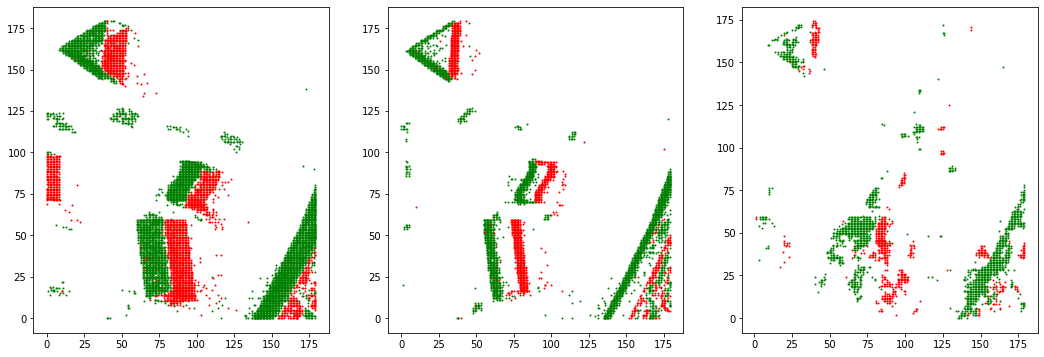

torch.Size([86400]) torch.Size([86400]) torch.Size([86400])
tensor(10000., device='cuda:0') tensor(5000., device='cuda:0') tensor(1683., device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([43200]) torch.Size([43200])
torch.Size([43200])


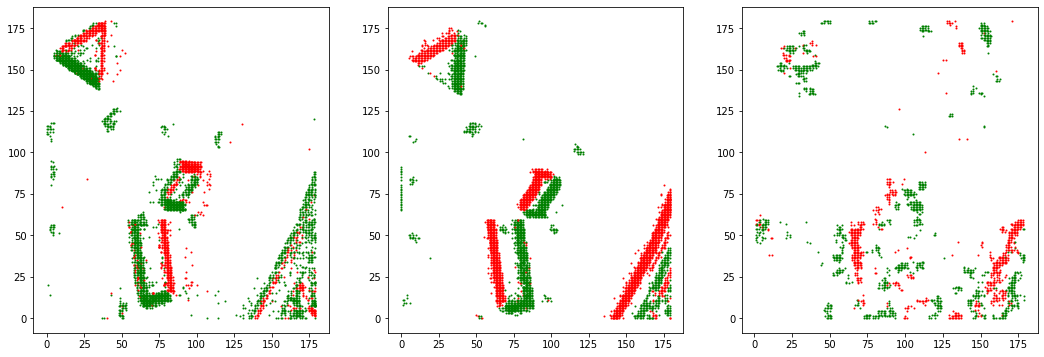

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

model.eval()
for i, (inputs, target) in enumerate(test_loader):
    inputs = inputs.float().transpose(2,3).transpose(1,2).reshape(-1, 1, input_size).to(device)
    target = target.float().transpose(2,3).transpose(1,2).reshape(-1, input_size).to(device)
    # Forward pass
    outputs = model(inputs)
    
    for idx, (events_in, events_out, result) in enumerate(zip(inputs,target,outputs.round())):
        fig = plt.figure(figsize=(18, 6))

        ax = fig.add_subplot(131)
        la = fig.add_subplot(132)
        out = fig.add_subplot(133)
        events_in = events_in[0]
        print(events_in.size(),events_out.size(),result.size())
        print(events_in.sum(),events_out.sum(),result.sum())
        print(events_in[:240*180].size(), events_in[240*180:].size())

        histo = torch.zeros(240*180).to(device)
        print(histo.size())
        histo = events_in[:240*180] - events_in[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                ax.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

        histo = events_out[:240*180] - events_out[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                la.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

        histo = result[:240*180] - result[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                out.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

        plt.show()
        break
        
    loss = criterion(outputs, target)
    print(loss)
    break


In [ ]:
# Train the model

model2.train()
num_epochs=Config.num_epochs
n_total_steps = len(train_loader)

optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, betas=(0.9,0.999))

for epoch in range(num_epochs):
    for i, (inputs, target) in enumerate(train_loader):  

        # origin shape: [N, 1, 240*180]
        # resized: [N, 240*180]
        inputs = inputs.float().transpose(2,3).transpose(1,2).reshape(-1, 1, input_size).to(device)
        target = target.float().transpose(2,3).transpose(1,2).reshape(-1, input_size).to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model2(inputs)

        m = torch.nn.Sigmoid()
        loss = criterion(outputs, m(target))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/300], Step [5/29], Loss: 0.6932
Epoch [1/300], Step [10/29], Loss: 0.6930
Epoch [1/300], Step [15/29], Loss: 0.6929
Epoch [1/300], Step [20/29], Loss: 0.6928
Epoch [1/300], Step [25/29], Loss: 0.6927
Epoch [2/300], Step [5/29], Loss: 0.6927
Epoch [2/300], Step [10/29], Loss: 0.6927
Epoch [2/300], Step [15/29], Loss: 0.6927
Epoch [2/300], Step [20/29], Loss: 0.6927
Epoch [2/300], Step [25/29], Loss: 0.6927
Epoch [3/300], Step [5/29], Loss: 0.6927
Epoch [3/300], Step [10/29], Loss: 0.6927
Epoch [3/300], Step [15/29], Loss: 0.6927
Epoch [3/300], Step [20/29], Loss: 0.6927
Epoch [3/300], Step [25/29], Loss: 0.6927
Epoch [4/300], Step [5/29], Loss: 0.6927
Epoch [4/300], Step [10/29], Loss: 0.6927
Epoch [4/300], Step [15/29], Loss: 0.6927
Epoch [4/300], Step [20/29], Loss: 0.6927
Epoch [4/300], Step [25/29], Loss: 0.6926
Epoch [5/300], Step [5/29], Loss: 0.6927
Epoch [5/300], Step [10/29], Loss: 0.6927
Epoch [5/300], Step [15/29], Loss: 0.6927
Epoch [5/300], Step [20/29], Loss: 0.69

torch.Size([86400]) torch.Size([86400]) torch.Size([86400])
tensor(10000., device='cuda:0') tensor(5000., device='cuda:0') tensor(3076., device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([43200]) torch.Size([43200])
torch.Size([43200])


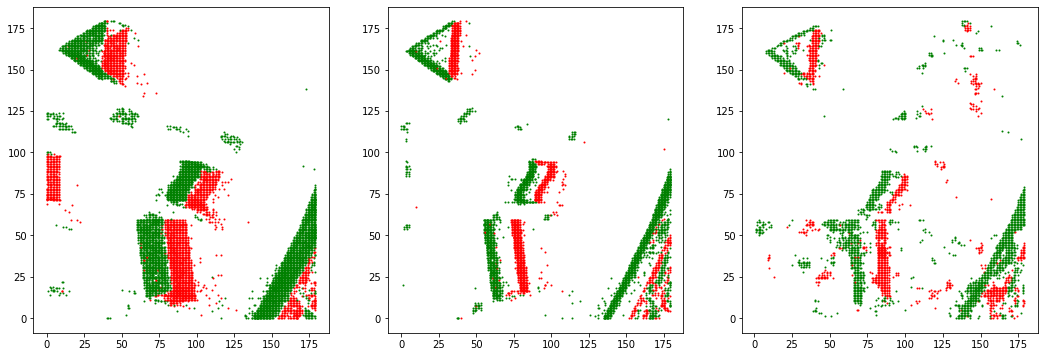

tensor(0.7034, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


In [ ]:
import matplotlib.pyplot as plt

model2.eval()
for i, (inputs, target) in enumerate(test_loader):
    inputs = inputs.float().transpose(2,3).transpose(1,2).reshape(-1, 1, input_size).to(device)
    target = target.float().transpose(2,3).transpose(1,2).reshape(-1, input_size).to(device)
    # Forward pass
    outputs = model2(inputs)
    
    for idx, (events_in, events_out, result) in enumerate(zip(inputs,target,outputs.round())):
        fig = plt.figure(figsize=(18, 6))

        ax = fig.add_subplot(131)
        la = fig.add_subplot(132)
        out = fig.add_subplot(133)
        events_in = events_in[0]
        print(events_in.size(),events_out.size(),result.size())
        print(events_in.sum(),events_out.sum(),result.sum())
        print(events_in[:240*180].size(), events_in[240*180:].size())

        histo = torch.zeros(240*180).to(device)
        print(histo.size())
        histo = events_in[:240*180] - events_in[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                ax.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

        histo = events_out[:240*180] - events_out[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                la.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

        histo = result[:240*180] - result[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                out.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

        plt.show()
        break
        
    loss = criterion(outputs, target)
    print(loss)
    break

##Test

tensor(767973.3750, device='cuda:0', grad_fn=<SumBackward0>) tensor(705611.8750, device='cuda:0', grad_fn=<SumBackward0>) tensor(919372.2500, device='cuda:0', grad_fn=<SumBackward0>)
tensor(20246., device='cuda:0') tensor(15301., device='cuda:0') tensor(13999., device='cuda:0', grad_fn=<SumBackward0>) tensor(11203., device='cuda:0', grad_fn=<SumBackward0>) tensor(13824., device='cuda:0', grad_fn=<SumBackward0>)


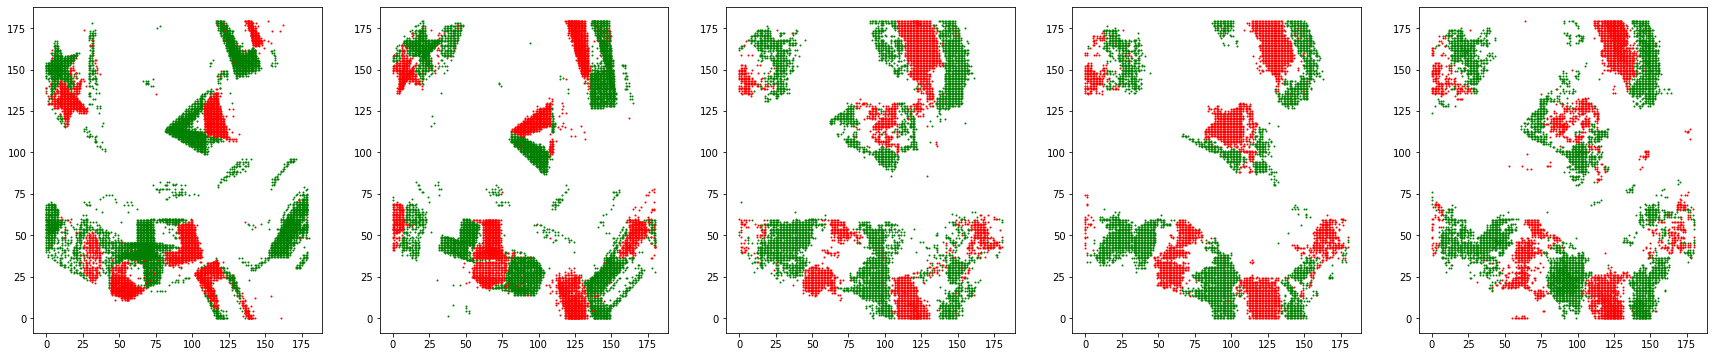

tensor(785494.6250, device='cuda:0', grad_fn=<SumBackward0>) tensor(756607.1250, device='cuda:0', grad_fn=<SumBackward0>) tensor(967349.5000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(35668., device='cuda:0') tensor(9384., device='cuda:0') tensor(7758., device='cuda:0', grad_fn=<SumBackward0>) tensor(9229., device='cuda:0', grad_fn=<SumBackward0>) tensor(9202., device='cuda:0', grad_fn=<SumBackward0>)


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f154338fef0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

model.eval()
model1.eval()
model2.eval()
for i, (images, labels) in enumerate(train_loader):
    if (i < 10):
        continue
    images = images.float().transpose(2,3).transpose(1,2).reshape(-1, 1, input_size).to(device)
    labels = labels.float().transpose(2,3).transpose(1,2).reshape(-1, input_size).to(device)
    # Forward pass
    outputs = model(images)
    outputs1 = model1(images)
    outputs2 = model2(images)
    print(outputs.sum(),outputs1.sum(),outputs2.sum())
    for idx, (events_in, events_out, result, result1, result2) in enumerate(zip(images,labels,outputs.round(),outputs1.round(),outputs2.round())):
        fig = plt.figure(figsize=(30, 6))

        ax = fig.add_subplot(151)
        la = fig.add_subplot(152)
        out = fig.add_subplot(153)
        out1 = fig.add_subplot(154)
        out2 = fig.add_subplot(155)

        events_in = events_in[0]

        print(events_in.sum(),events_out.sum(),result.sum(),result1.sum(),result2.sum())

        histo = torch.zeros(240*180).to(device)

        histo = events_in[:240*180] - events_in[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                ax.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

#            for i in range(len(events_in)):
#                if (events_in[i]!=0):
#                    if (i<240*180):
#                        ax.scatter((i)//180,(i)%180, c="green", s=events_in[i].item())
#                    else:
#                        ax.scatter((i-240*180)//180,(i-240*180)%180, c="red", s=events_in[i].item())

        histo = events_out[:240*180] - events_out[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                la.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

#            for i in range(len(events_out)):
#                if (events_out[i]!=0):
#                    if (i<240*180):
#                        la.scatter((i)//180,(i)%180, c="green", s=events_out[i].item())
#                    else:
#                        la.scatter((i-240*180)//180,(i-240*180)%180, c="red", s=events_out[i].item())
        
        histo = result[:240*180] - result[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                out.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

#            for i in range(len(result)):
#                if (result[i]!=0):
#                    if (i<240*180):
#                        out.scatter((i)//180,(i)%180, c="green", s=result[i].item())
#                    else:
#                        out.scatter((i-240*180)//180,(i-240*180)%180, c="red", s=result[i].item())

        histo = result1[:240*180] - result1[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                out1.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

        histo = result2[:240*180] - result2[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                out2.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

        plt.show()
        break
    break


##Dummy Codes

In [ ]:
# Train the model

model2.train()
num_epochs=Config.num_epochs
n_total_steps = len(train_loader)

optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, betas=(0.9,0.999))

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        images = images.float().transpose(2,3).transpose(1,2).reshape(-1, 1, input_size).to(device)
        labels = labels.float().transpose(2,3).transpose(1,2).reshape(-1, input_size).to(device)

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model2(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        if (i+1) % 3 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/100], Step [3/16], Loss: 0.1492
Epoch [1/100], Step [6/16], Loss: 0.2603
Epoch [1/100], Step [9/16], Loss: 0.2769
Epoch [1/100], Step [12/16], Loss: 0.3029
Epoch [1/100], Step [15/16], Loss: 0.3098
Epoch [2/100], Step [3/16], Loss: 0.1600
Epoch [2/100], Step [6/16], Loss: 0.2419
Epoch [2/100], Step [9/16], Loss: 0.2687
Epoch [2/100], Step [12/16], Loss: 0.3081
Epoch [2/100], Step [15/16], Loss: 0.3107
Epoch [3/100], Step [3/16], Loss: 0.1525
Epoch [3/100], Step [6/16], Loss: 0.2406
Epoch [3/100], Step [9/16], Loss: 0.2631
Epoch [3/100], Step [12/16], Loss: 0.2973
Epoch [3/100], Step [15/16], Loss: 0.3048
Epoch [4/100], Step [3/16], Loss: 0.1487
Epoch [4/100], Step [6/16], Loss: 0.2388
Epoch [4/100], Step [9/16], Loss: 0.2616
Epoch [4/100], Step [12/16], Loss: 0.2945
Epoch [4/100], Step [15/16], Loss: 0.3036
Epoch [5/100], Step [3/16], Loss: 0.1438
Epoch [5/100], Step [6/16], Loss: 0.2373
Epoch [5/100], Step [9/16], Loss: 0.2595
Epoch [5/100], Step [12/16], Loss: 0.2917
Epoch [

torch.Size([86400]) torch.Size([86400]) torch.Size([86400])
tensor(16255., device='cuda:0') tensor(13701., device='cuda:0') tensor(14308., device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([43200]) torch.Size([43200])
torch.Size([43200])


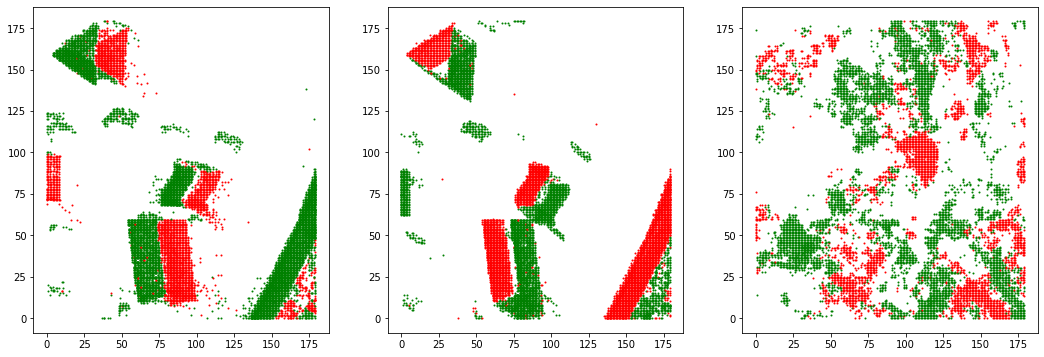

tensor(0.3058, device='cuda:0', grad_fn=<MseLossBackward>)


In [ ]:
import matplotlib.pyplot as plt

model2.eval()
for i, (images, labels) in enumerate(test_loader):
    images = images.float().transpose(2,3).transpose(1,2).reshape(-1, 1, input_size).to(device)
    labels = labels.float().transpose(2,3).transpose(1,2).reshape(-1, input_size).to(device)
    # Forward pass
    outputs = model2(images)
    for idx, (events_in, events_out, result) in enumerate(zip(images,labels,outputs.round())):
        fig = plt.figure(figsize=(18, 6))

        ax = fig.add_subplot(131)
        la = fig.add_subplot(132)
        out = fig.add_subplot(133)
        events_in = events_in[0]
        print(events_in.size(),events_out.size(),result.size())
        print(events_in.sum(),events_out.sum(),result.sum())
        print(events_in[:240*180].size(), events_in[240*180:].size())

        histo = torch.zeros(240*180).to(device)
        print(histo.size())
        histo = events_in[:240*180] - events_in[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                ax.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

        histo = events_out[:240*180] - events_out[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                la.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

        histo = result[:240*180] - result[240*180:]
        for i in range(len(histo)):
            if (histo[i]!=0):
                out.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

        plt.show()
        break
    
    loss = criterion(outputs, labels)
    print(loss)
    break


torch.Size([86400]) torch.Size([86400]) torch.Size([86400])
tensor(16255., device='cuda:0') tensor(11023., device='cuda:0') tensor(3533., device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([43200]) torch.Size([43200])
torch.Size([43200])


KeyboardInterrupt: ignored

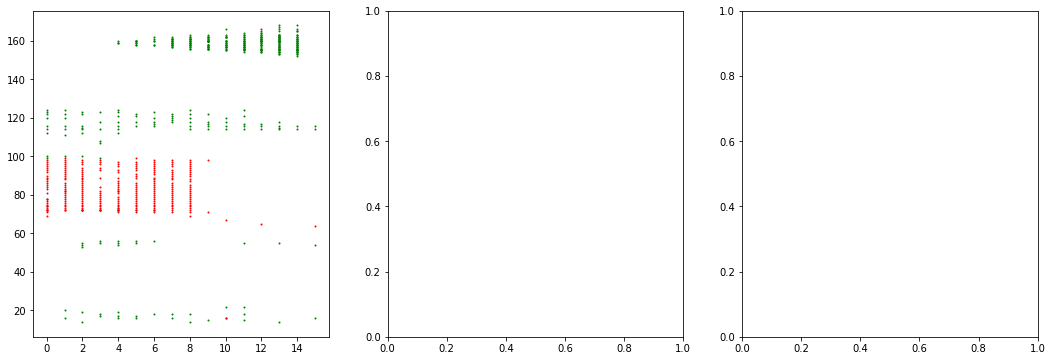

In [ ]:
import matplotlib.pyplot as plt

model.eval()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(test_loader):
        if (i>10):
            break
        images = images.float().transpose(2,3).transpose(1,2).reshape(-1, 1, input_size).to(device)
        labels = labels.float().transpose(2,3).transpose(1,2).reshape(-1, input_size).to(device)
        # Forward pass
        outputs = model(images)
        
        for idx, (events_in, events_out, result) in enumerate(zip(images,labels,outputs.round())):
            fig = plt.figure(figsize=(18, 6))

            ax = fig.add_subplot(131)
            la = fig.add_subplot(132)
            out = fig.add_subplot(133)
            events_in = events_in[0]
            print(events_in.size(),events_out.size(),result.size())
            print(events_in.sum(),events_out.sum(),result.sum())
            print(events_in[:240*180].size(), events_in[240*180:].size())

            histo = torch.zeros(240*180).to(device)
            print(histo.size())
            histo = events_in[:240*180] - events_in[240*180:]
            for i in range(len(histo)):
                if (histo[i]!=0):
                    ax.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

#            for i in range(len(events_in)):
#                if (events_in[i]!=0):
#                    if (i<240*180):
#                        ax.scatter((i)//180,(i)%180, c="green", s=events_in[i].item())
#                    else:
#                        ax.scatter((i-240*180)//180,(i-240*180)%180, c="red", s=events_in[i].item())

            histo = events_out[:240*180] - events_out[240*180:]
            for i in range(len(histo)):
                if (histo[i]!=0):
                    la.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

#            for i in range(len(events_out)):
#                if (events_out[i]!=0):
#                    if (i<240*180):
#                        la.scatter((i)//180,(i)%180, c="green", s=events_out[i].item())
#                    else:
#                        la.scatter((i-240*180)//180,(i-240*180)%180, c="red", s=events_out[i].item())
            
            histo = result[:240*180] - result[240*180:]
            for i in range(len(histo)):
                if (histo[i]!=0):
                    out.scatter((i)//180,(i)%180, c=("green" if histo[i].item()>0 else "red"), s=abs(histo[i].item()))

#            for i in range(len(result)):
#                if (result[i]!=0):
#                    if (i<240*180):
#                        out.scatter((i)//180,(i)%180, c="green", s=result[i].item())
#                    else:
#                        out.scatter((i-240*180)//180,(i-240*180)%180, c="red", s=result[i].item())

            plt.show()
        
        loss = criterion(outputs, labels)
        print(loss)


In [ ]:
test = EventHistogram("data/0/events.txt",Config,train=False)

test_loader = DataLoader(dataset=test,batch_size=Config.batch_size)

23126288
4625258
data/0/events.txt 510 tensor(271372) tensor(335541) || tensor(64169.) tensor(10311.)
data/0/events.txt 520 tensor(752746) tensor(795117) || tensor(42371.) tensor(21059.)
data/0/events.txt 530 tensor(1245795) tensor(1286069) || tensor(40274.) tensor(12584.)
data/0/events.txt 540 tensor(1739140) tensor(1797438) || tensor(58298.) tensor(15095.)
data/0/events.txt 550 tensor(2252043) tensor(2305121) || tensor(53078.) tensor(14814.)
data/0/events.txt 560 tensor(2768549) tensor(2813539) || tensor(44990.) tensor(5612.)
data/0/events.txt 570 tensor(3236455) tensor(3282791) || tensor(46336.) tensor(14045.)
data/0/events.txt 580 tensor(3728284) tensor(3776809) || tensor(48525.) tensor(12492.)
data/0/events.txt 590 tensor(4222651) tensor(4264282) || tensor(41631.) tensor(12553.)
data/0/events.txt 598 finished


In [ ]:
from torch.utils.data import DataLoader
import torch
import torchvision
import math

first_data = dataset[0]
inputs, outputs = first_data
print(inputs.size(), outputs.size())

total_samples = len(dataset)
n_iteration = math.ceil(total_samples/Config.batch_size)

for epoch in range(Config.num_epochs):

    for i, (inputs, outputs) in enumerate(dataloader):
        if (i+1) % 5 == 0 :
            print("epoch "+str(epoch+1)+'/'+str(Config.num_epochs)+", step "+str(i+1)+'/'+str(n_iteration)+", inputs :",(inputs.shape),"outputs :",(outputs.shape))

In [ ]:
events = torch.from_numpy(np.loadtxt("data/0/events.txt").astype(np.float32))
num_events = 23126288

train=False

print(events.size())
print(num_events)

if (train==True):
    print("True")
    temp = events[:-num_events//20]
else :
    print("False")
    temp = events[-num_events//20:]

print(temp.size())


In [ ]:
#test for tensor reshape
a = torch.tensor([[[1,2],[3,4],[5,6]],[[1,0],[1,0],[1,0]],[[1,0],[1,0],[1,0]],[[1,0],[1,0],[1,0]]]).T.transpose(1,2)

print(a)
print(a.reshape(-1))
a.size()
#test for tensor reshape
b = torch.cat([dataset[0][0].unsqueeze(dim=0),dataset[0][1].unsqueeze(dim=0)])

print(a.size())

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
events_in = b.transpose(2,3).transpose(1,2).reshape(-1,240*180*2)
print(events_in.size())
print(events_in.sum())
for events in (events_in):
    for i in range(len(events)):
        if (events[i]!=0):
            if (i<240*180):
                ax.scatter((i)//180,(i)%180, c="green", s=events[i].item())
            else:
                ax.scatter((i-240*180)//180,(i-240*180)%180, c="red", s=events[i].item())
plt.show()

In [ ]:
print(train[:][0].size())
print(test[:][0].size())

torch.Size([505, 240, 180, 2])
torch.Size([94, 240, 180, 2])


In [ ]:
test_loader = DataLoader(dataset=test,batch_size=Config.batch_size)

test.x.size()
test.y.size()

for i, (images, labels) in enumerate(test_loader):
    print(images.size())

torch.Size([94, 240, 180, 2])

In [ ]:
frame_size = 10000
padding = 3000

for i in range(10):
    start_frame = max((i * frame_size - padding), 0)
    end_frame = min((i * frame_size + padding), 100000)

    histo = generate_event_histogram(events[start_frame:end_frame],[240,180])
    
    on=0
    off=0

    ax = fig.add_subplot(111)
    for i,x in enumerate(histo):
        for j,y in enumerate(x):
            if (y[0]>0 or y[1]>0):
                ax.scatter(i,j, c="red", s=y[0])
                ax.scatter(i,j, c="green", s=y[1])
            off=off+y[0]
            on=on+y[1]
    plt.show()
    print(on,off)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


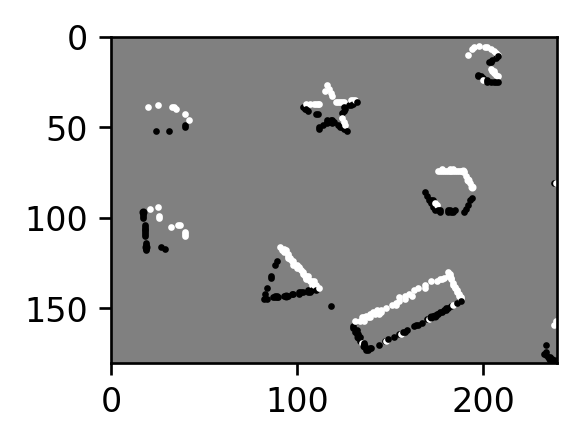

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(2.4, 1.8),dpi=240)

#Histogram

find = np.where(histogram!=0)
for i in range(np.shape(find)[1]):
    plt.scatter(find[0][i],find[1][i],s=abs(histogram[find[0][i], find[1][i]]), color=('black' if histogram[find[0][i], find[1][i]]<0 else 'white'))

plt.xlim(0,240)
plt.ylim(180, 0)
plt.axes().axis('off')

plt.savefig(fname="foo.png",facecolor="grey", bbox_inches='tight', pad_inches=0)
plt.axes().axis('on')
plt.rcParams['axes.facecolor'] = 'grey'

plt.show()


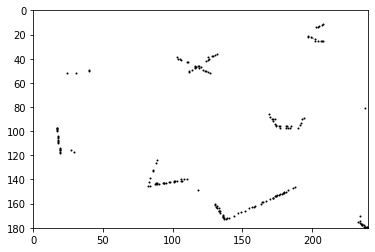

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math

plt.close()
plt.figure(figsize=(6, 4))

plt.rcParams['axes.facecolor'] = 'white'
find = np.where(histogram!=0)
for i in range(np.shape(find)[1]):
    plt.scatter(find[0][i],find[1][i],s=abs(histogram[find[0][i], find[1][i]]), c=('black' if histogram[find[0][i], find[1][i]]<0 else 'white'))

plt.xlim(0,240)
plt.ylim(180, 0)

plt.savefig('sin.png', bbox_inches='tight', pad_inches=0)